In [3]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import pickle
import warnings
from sklearn.utils import check_random_state

warnings.filterwarnings("ignore")

# 设置随机种子
np.random.seed(2024)
random_state = check_random_state(2024)

# 读取数据
data = pd.read_excel('/Users/zhangtongyi/Desktop/P0022024-认知聚类-project(最新版）/B.数据分析阶段定期备份/2024-11-16版/3.基线数据分析/2.聚类分析/0.数据预处理/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 （随访数据）/2.基于对照的 EF z-score 标准化患者的 EF 值，然后基于对照组得到的回归系数校正患者 EF 值的人口学效应 /table/校正并标准化后的患者行为变量数据.xlsx')
EFs_data = data[['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc',
                 'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']]
EFs_data_scaled = EFs_data.values

# 设置参数搜索范围
n_components_range = range(2, 8)
covariance_types = ['full']
reg_covar_range = [1e-2]
init_params = ['k-means++', 'random']
n_init = [1500]



# 创建字典以保存每个组合下的最佳参数和评分
best_params_scores = {}

# 稳定性分析
num_subsamples = 300
subsample_size = int(0.85 * len(EFs_data_scaled))

# 开始参数搜索
for n_components in n_components_range:
    for covariance_type in covariance_types:
        for reg_covar in reg_covar_range:
            print(f"Running EM with n_components = {n_components}, covariance_type = {covariance_type}, reg_covar = {reg_covar}")
            
            # 初始化GMM模型
            gmm_model = GaussianMixture(n_components=n_components, covariance_type=covariance_type,
                                        max_iter=1000, tol=1e-3, reg_covar=reg_covar, random_state=random_state)
            
            # 拟合模型
            gmm_model.fit(EFs_data_scaled)
            
            # 获取BIC和AIC
            mean_bic_score = gmm_model.bic(EFs_data_scaled)
            mean_aic_score = gmm_model.aic(EFs_data_scaled)

            # Calculate standard deviations for BIC and AIC scores in stability analysis
            bic_scores = []
            aic_scores = []
            stabilities = []

            for _ in range(num_subsamples):
                subsample_indices = np.random.choice(len(EFs_data_scaled), subsample_size, replace=False)
                subsample_data = EFs_data_scaled[subsample_indices]
                
                subsample_gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type,
                                                max_iter=1000, tol=1e-3, reg_covar=reg_covar, random_state=random_state)
                subsample_gmm.fit(subsample_data)
                subsample_labels = subsample_gmm.predict(subsample_data)
                
                full_data_labels = gmm_model.predict(EFs_data_scaled)
                subsample_full_labels = full_data_labels[subsample_indices]
                
                # Add scores to lists
                bic_scores.append(subsample_gmm.bic(subsample_data))
                aic_scores.append(subsample_gmm.aic(subsample_data))
                stability = adjusted_rand_score(subsample_labels, subsample_full_labels)
                stabilities.append(stability)

            std_bic_score = np.std(bic_scores)
            std_aic_score = np.std(aic_scores)
            mean_stability = np.mean(stabilities)
            std_stability = np.std(stabilities)
            # 计算 95% 置信区间
            bic_ci = np.percentile(bic_scores, [2.5, 97.5])
            aic_ci = np.percentile(aic_scores, [2.5, 97.5])
            stability_ci = np.percentile(stabilities, [2.5, 97.5])
            
            # 将每个组合的结果保存到字典中
            best_params_scores[(n_components, covariance_type, reg_covar)] = {
                'mean_bic_score': mean_bic_score,
                'std_bic_score': std_bic_score,
                'bic_ci_lower': bic_ci[0],
                'bic_ci_upper': bic_ci[1],
                'mean_aic_score': mean_aic_score,
                'std_aic_score': std_aic_score,
                'aic_ci_lower': aic_ci[0],
                'aic_ci_upper': aic_ci[1],
                'mean_stability': mean_stability,
                'std_stability': std_stability,
                'stability_ci_lower': stability_ci[0],
                'stability_ci_upper': stability_ci[1],
                'cluster_centers': gmm_model.means_
            }
            

            print(f"BIC score: {mean_bic_score:.3f} ± {std_bic_score:.3f}, AIC score: {mean_aic_score:.3f} ± {std_aic_score:.3f}, Stability: {mean_stability:.3f} ± {std_stability:.3f}")

# 根据 BIC 得分找到最佳参数组合
best_params = min(best_params_scores, key=lambda k: best_params_scores[k]['mean_bic_score'])
print(f"Best parameters: n_components={best_params[0]}, covariance_type={best_params[1]}, reg_covar={best_params[2]}")


# 保存所有参数组合及其得分到Excel文件
all_params_df = pd.DataFrame([
    {
        'n_components': params[0],
        'covariance_type': params[1],
        'reg_covar': params[2],
        'mean_bic_score': scores['mean_bic_score'],
        'std_bic_score': scores['std_bic_score'],
        'bic_ci_lower': scores['bic_ci_lower'],
        'bic_ci_upper': scores['bic_ci_upper'],
        'mean_aic_score': scores['mean_aic_score'],
        'std_aic_score': scores['std_aic_score'],
        'aic_ci_lower': scores['aic_ci_lower'],
        'aic_ci_upper': scores['aic_ci_upper'],
        'mean_stability': scores['mean_stability'],
        'std_stability': scores['std_stability'],
        'stability_ci_lower': scores['stability_ci_lower'],
        'stability_ci_upper': scores['stability_ci_upper']
    }
    for params, scores in best_params_scores.items()
])


# 保存为Excel文件
all_params_df.to_excel('table/BIC_AIC_Stability_Scores.xlsx', index=False)
print("所有模型参数组合的 BIC, AIC 以及稳定性已保存到 'BIC_AIC_Stability_Scores.xlsx'")

# 基于最佳参数的模型计算隶属度，并保存到Excel文件
best_gmm_estimator = GaussianMixture(n_components=best_params[0], covariance_type=best_params[1],
                                     max_iter=1000, tol=1e-3, reg_covar=best_params[2], random_state=random_state)
best_gmm_estimator.fit(EFs_data_scaled)

membership_probabilities = best_gmm_estimator.predict_proba(EFs_data_scaled)
membership_df = pd.DataFrame(membership_probabilities, columns=[f'Cluster_{i+1}' for i in range(best_params[0])])
membership_df.to_excel('table/隶属度.xlsx', index=False)

# 保存聚类中心
centers_df = pd.DataFrame(best_gmm_estimator.means_, columns=EFs_data.columns)
centers_df.to_excel('table/聚类中心.xlsx', index=False)

# 打印并保存最佳模型的标签
labels = best_gmm_estimator.predict(EFs_data_scaled)
print("最佳模型的标签：", labels)

# 将标签保存到Excel文件
labels_df = pd.DataFrame(labels, columns=['Cluster_Label'])
labels_df.to_excel('table/标签.xlsx', index=False)

# 创建DataFrame并打印（更易读的格式）
membership_df = pd.DataFrame(membership_probabilities, columns=[f'Cluster_{i+1}' for i in range(best_params[0])])
print("\nGMM概率值的DataFrame格式：")
print(membership_df)

# 将概率值保存到Excel文件
membership_df.to_excel('table/GMM_probabilities.xlsx', index=True)
print("\nGMM概率值已保存到 'GMM_probabilities.xlsx'")

# 如果想要同时保存标签和概率值
results_df = pd.DataFrame({
    'GMM_Label': labels,
    **{f'GMM_Cluster{i}_Prob': membership_probabilities[:, i] for i in range(best_params[0])}
})
results_df.to_excel('table/GMM_labels_and_probabilities.xlsx', index=True)
print("标签和概率值已保存到 'GMM_labels_and_probabilities.xlsx'")

Running EM with n_components = 2, covariance_type = full, reg_covar = 0.01
BIC score: 6967.474 ± 21.751, AIC score: 6749.137 ± 21.751, Stability: 0.526 ± 0.245
Running EM with n_components = 3, covariance_type = full, reg_covar = 0.01
BIC score: 7093.349 ± 24.773, AIC score: 6764.305 ± 24.773, Stability: 0.262 ± 0.133
Running EM with n_components = 4, covariance_type = full, reg_covar = 0.01
BIC score: 7183.181 ± 28.759, AIC score: 6743.431 ± 28.759, Stability: 0.295 ± 0.133
Running EM with n_components = 5, covariance_type = full, reg_covar = 0.01
BIC score: 7339.350 ± 28.954, AIC score: 6788.894 ± 28.954, Stability: 0.335 ± 0.099
Running EM with n_components = 6, covariance_type = full, reg_covar = 0.01
BIC score: 7481.936 ± 35.030, AIC score: 6820.773 ± 35.030, Stability: 0.421 ± 0.092
Running EM with n_components = 7, covariance_type = full, reg_covar = 0.01
BIC score: 7569.010 ± 37.713, AIC score: 6797.142 ± 37.713, Stability: 0.343 ± 0.087
Best parameters: n_components=2, covaria

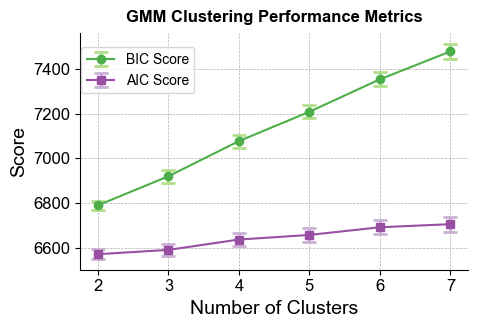

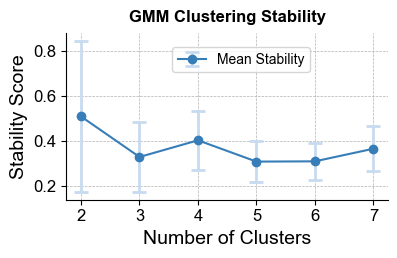

In [420]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 从 best_params_scores 中提取每个 cluster (n_components) 最佳 BIC 模型的 BIC 和 AIC
unique_n_components = sorted(set(params[0] for params in best_params_scores.keys()))
best_bic_scores = []
std_bic_scores = []
best_aic_scores = []
std_aic_scores = []

for n in unique_n_components:
    # 筛选当前 n_components 下 BIC 最小的模型
    best_model = min(
        [(params, scores) for params, scores in best_params_scores.items() if params[0] == n],
        key=lambda x: x[1]['mean_bic_score']
    )
    best_bic_scores.append(best_model[1]['mean_bic_score'])
    std_bic_scores.append(best_model[1]['std_bic_score'])
    best_aic_scores.append(best_model[1]['mean_aic_score'])
    std_aic_scores.append(best_model[1]['std_aic_score'])

# 绘制 BIC 和 AIC 的折线图
fig, ax = plt.subplots(figsize=(5, 3.5), facecolor='w')

# 设置颜色
bic_line_color = '#4daf4a'  # 深绿色
bic_error_color = '#b2df8a'  # 浅绿色
aic_line_color = '#984ea3'  # 深紫色
aic_error_color = '#cab2d6'  # 浅紫色

# 绘制 BIC 折线图
ax.errorbar(unique_n_components, best_bic_scores, yerr=std_bic_scores, fmt='-o', capsize=5,
            color=bic_line_color, ecolor=bic_error_color, elinewidth=2, capthick=2, label='BIC Score')

# 绘制 AIC 折线图
ax.errorbar(unique_n_components, best_aic_scores, yerr=std_aic_scores, fmt='-s', capsize=5,
            color=aic_line_color, ecolor=aic_error_color, elinewidth=2, capthick=2, label='AIC Score')

# 设置图形标题和标签
ax.set_title('GMM Clustering Performance Metrics', fontsize=12, weight='bold', pad=8)
ax.set_xlabel('Number of Clusters', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_facecolor('w')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# 添加图例，并设置位置和字体大小
ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(0.33, 1.0), borderaxespad=1.)

# 保存图表为高分辨率JPEG文件
fig.tight_layout()
fig.savefig('image/BIC_and_AIC_best_models.jpg', dpi=1200, format='jpg', bbox_inches='tight')

# 显示图形
plt.show()


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# 设置字体大小和样式
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
})

# Nature风格配色方案
stability_line_color = '#377eb8'  # 深蓝色
stability_error_color = '#c6dbef'  # 浅蓝色

# 从 best_params_scores 中提取 n_components 和稳定性数据
unique_n_components = sorted(set(params[0] for params in best_params_scores.keys()))
mean_stabilities = []
std_stabilities = []

for n in unique_n_components:
    best_model = min(
        [(params, scores) for params, scores in best_params_scores.items() if params[0] == n],
        key=lambda x: x[1]['mean_bic_score']
    )
    mean_stabilities.append(best_model[1]['mean_stability'])
    std_stabilities.append(best_model[1]['std_stability'])

# 创建一个图表
fig, ax = plt.subplots(figsize=(4.2, 2.8), facecolor='w')

# 绘制稳定性折线图
ax.errorbar(unique_n_components, mean_stabilities, yerr=std_stabilities, fmt='-o', capsize=5,
            color=stability_line_color, ecolor=stability_error_color, elinewidth=2, capthick=2, label='Mean Stability')

# 设置标题和标签
ax.set_title('GMM Clustering Stability', fontsize=12, weight='bold', pad=8)
ax.set_xlabel('Number of Clusters', fontsize=14)
ax.set_ylabel('Stability Score', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_facecolor('w')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# 添加图例，并设置位置和字体大小
ax.legend(loc='upper right', fontsize=10, bbox_to_anchor=(0.8, 1.0), borderaxespad=1.)

# 保存图表为高分辨率JPEG文件
fig.tight_layout()
fig.savefig('./image/stability_nature_style_plot.jpg', dpi=1200, format='jpg', bbox_inches='tight')

# 显示图形
plt.show()

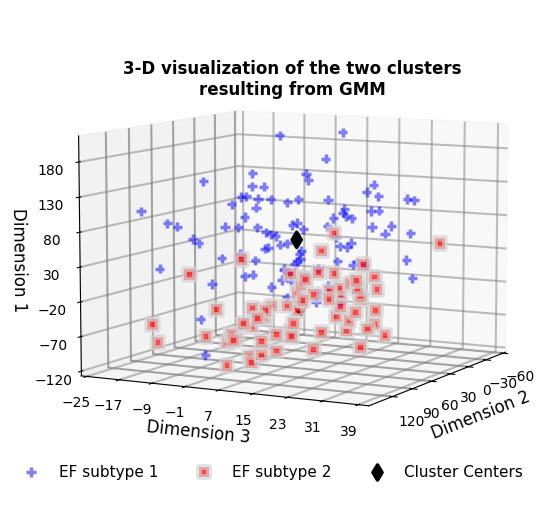

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np

# 使用PCA将7维数据降到3维
pca = PCA(n_components=3)
EFs_data_pca = pca.fit_transform(EFs_data_scaled)

# 可视化聚类结果(3D)
fig = plt.figure(figsize=(8, 5.2))
ax = fig.add_subplot(111, projection='3d')

# 将 labels 中的值映射为两种颜色：Cluster 1（红色），Cluster 2（蓝色）
colors = ['red' if label == 0 else 'blue' for label in labels]

# 绘制散点图：分别为 Cluster 1 和 Cluster 2，X轴和Y轴对调
sc1 = ax.scatter(
    EFs_data_pca[labels == 0, 1],
    EFs_data_pca[labels == 0, 2],
    EFs_data_pca[labels == 0, 0],
    c='red',
    edgecolors='lightgrey',
    s=60, alpha=0.7,
    marker='s',
    label='EF subtype 2',
    zorder=0, lw=4
)
sc2 = ax.scatter(
    EFs_data_pca[labels == 1, 1],
    EFs_data_pca[labels == 1, 2],
    EFs_data_pca[labels == 1, 0],
    c='blue',
    edgecolors='black',
    s=45, alpha=0.5,
    marker='+',
    label='EF subtype 1',
    zorder=0, lw=2.5
)

# 设置标题和坐标轴标签
ax.set_title(
    '3-D visualization of the two clusters\nresulting from GMM',
    fontsize=12, fontweight='bold', y=0.88
)
ax.set_xlabel('Dimension 2', fontsize=12)
ax.set_ylabel('Dimension 3', fontsize=12)
ax.set_zlabel('Dimension 1', fontsize=12)

# 设置坐标轴的取值范围和刻度
ax.set_xlim(-60, 150)
ax.set_ylim(-25, 40)
ax.set_zlim(-120, 210)
ax.set_xticks(np.arange(-60, 150, 30))
ax.set_yticks(np.arange(-25, 40, 8))
ax.set_zticks(np.arange(-120, 210, 50))

# 设置网格线的颜色和粗细
ax.xaxis._axinfo["grid"]['color']     = (0.5, 0.5, 0.5, 0.7)
ax.yaxis._axinfo["grid"]['color']     = (0.5, 0.5, 0.5, 0.5)
ax.zaxis._axinfo["grid"]['color']     = (0.5, 0.5, 0.5, 0.5)
ax.xaxis._axinfo["grid"]['linestyle'] = '-'
ax.yaxis._axinfo["grid"]['linestyle'] = '-'
ax.zaxis._axinfo["grid"]['linestyle'] = '-'
ax.xaxis._axinfo["grid"]['linewidth'] = 1.5
ax.yaxis._axinfo["grid"]['linewidth'] = 1.5
ax.zaxis._axinfo["grid"]['linewidth'] = 1.5

# 调整坐标轴刻度字体大小
ax.tick_params(axis='both', which='major', labelsize=10)

# 添加聚类中心，X轴和Z轴对调
centers_pca = pca.transform(best_gmm_estimator.means_)
ax.scatter(
    centers_pca[:, 1],
    centers_pca[:, 2],
    centers_pca[:, 0],
    c='black', s=60,
    alpha=1, marker='d',
    label='Cluster Centers',
    zorder=10, lw=2.5
)


# 手动重排图例顺序：先 subtype 1，再 subtype 2，最后 Cluster Centers
handles, labels = ax.get_legend_handles_labels()
desired_order = ['EF subtype 1', 'EF subtype 2', 'Cluster Centers']
order = [labels.index(lbl) for lbl in desired_order]
ax.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    fontsize=11, loc='upper right',
    frameon=True, edgecolor='none',
    facecolor='none', framealpha=0.8,
    bbox_to_anchor=(1, 0.1), ncol=3
)


# 调整图形布局
plt.tight_layout()

# 设置背景颜色
ax.set_facecolor('white')

# 设置网格线颜色和透明度
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

# 调整视角
ax.view_init(elev=8, azim=28)

# 获取 x, y, z 轴的最小和最大值
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
z_min, z_max = ax.get_zlim()

# 定义立方体的顶点坐标
vertices = np.array([
    [x_min, y_min, z_min],
    [x_max, y_min, z_min],
    [x_max, y_max, z_min],
    [x_min, y_max, z_min],
    [x_min, y_min, z_max],
    [x_max, y_min, z_max],
    [x_max, y_max, z_max],
    [x_min, y_max, z_max]
])

# 定义立方体的面
faces = [
    [vertices[0], vertices[1], vertices[2], vertices[3]],
    [vertices[4], vertices[5], vertices[6], vertices[7]],
    [vertices[0], vertices[1], vertices[5], vertices[4]],
    [vertices[2], vertices[3], vertices[7], vertices[6]],
    [vertices[1], vertices[2], vertices[6], vertices[5]],
    [vertices[4], vertices[7], vertices[3], vertices[0]]
]

# 绘制立方体的棱 (仅竖向连线)
for i in range(4):
    ax.plot(
        [vertices[i, 0], vertices[i+4, 0]],
        [vertices[i, 1], vertices[i+4, 1]],

        color='black', linewidth=0.5
    )

# 保存图形
plt.savefig(
    './image/GMM聚类结果可视化_3D_XY交换_edges_clean.jpg',
    dpi=1200, bbox_inches='tight'
)
plt.show()

## 全部完成

In [6]:
print("全部完成！")

全部完成！
